# ケーススタディ３： 時系列分析（Prophet）

様々な要因から予測する回帰と異なり、時系列分析は、結果に周期性があることを前提とした予測。
そのため「天気」「気温」「湿度」などの情報は一切、使わない。指定した未来の予測値の計算に、
入力データは必要ない。

また、結果に対して**信頼区間**が算出される。

本来は、深い数学的知識が必要とされるが、[Prophetパッケージ](https://github.com/facebook/prophet)
の登場で、誰でも利用できる形になっている。

In [167]:
!pip3 install -U ucimlrepo --break-system-packages | tail -1

In [181]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bike_sharing = fetch_ucirepo(id=275)

# data (as pandas dataframes)
X = bike_sharing.data.features
y = bike_sharing.data.targets

# metadata
print(bike_sharing.metadata)

# variable information
print(bike_sharing.variables)

{'uci_id': 275, 'name': 'Bike Sharing', 'repository_url': 'https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/275/data.csv', 'abstract': 'This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 17389, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['cnt'], 'index_col': ['instant'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5W894', 'creators': ['Hadi Fanaee-T'], 'intro_paper': {'title': 'Event labeling combining ensemble detectors and background knowledge', 'authors': 'Hadi Fanaee-T, João Gama', 'published_in': 'Progress in Artificial Intelli

In [182]:
import pandas as pd

X0 = pd.concat([X, y], axis=1)
X0 = X0.groupby('dteday', as_index=False).mean()
y0 = X0['cnt']
X0 = X0.drop(['hr', 'cnt'], axis=1)


In [185]:
X0.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.583333,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,1.0,0.0,1.0,0.0,0.0,0.0,1.956522,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1.0,0.0,1.0,0.0,1.0,1.0,1.000000,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1.0,0.0,1.0,0.0,2.0,1.0,1.043478,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1.0,0.0,1.0,0.0,3.0,1.0,1.000000,0.226957,0.229270,0.436957,0.186900


## 入力データの加工

In [187]:

# 以下のデータ形式、カラム名は、ハードコードされている！！！
X1 = pd.concat([X0['dteday'].map(pd.to_datetime), y0], axis=1)
X1.columns = ['ds', 'y']

print(X1.head())
print(X1.tail())

          ds          y
0 2011-01-01  41.041667
1 2011-01-02  34.826087
2 2011-01-03  61.318182
3 2011-01-04  67.913043
4 2011-01-05  69.565217
            ds           y
726 2012-12-27   88.083333
727 2012-12-28  128.958333
728 2012-12-29   55.875000
729 2012-12-30   74.833333
730 2012-12-31  113.708333


In [188]:
mday = pd.to_datetime('2012-11-1')

train_index = X1['ds'] < mday
test_index = X1['ds'] >= mday

x_train = X1[train_index]
x_test = X1[test_index]

dates_test = X1['ds'][test_index]

Text(0.5, 1.0, 'The number of users as a function of time')

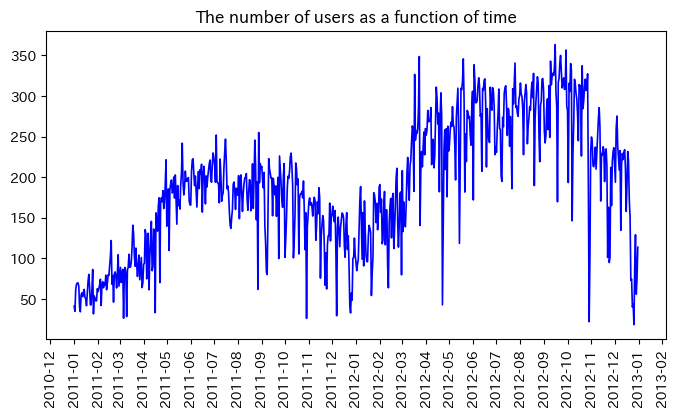

In [189]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(X1['ds'], X1['y'], c='b')
#weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
months = mdates.MonthLocator()
ax.xaxis.set_major_locator(months)

ax.tick_params(axis='x', rotation=90)
#ax.grid()
ax.set_title('The number of users as a function of time')

## 学習・予測

In [190]:
!pip3 install -U prophet --break-system-packages | tail -1

In [191]:
from prophet import Prophet

ml = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='multiplicative')
# seasonality_mode also takes 'additive' meaning that the predicated results are the addition of specific value,
# not percentage, which is 'multiplicative.'
ml.fit(x_train)

15:09:54 - cmdstanpy - INFO - Chain [1] start processing
15:09:54 - cmdstanpy - INFO - Chain [1] done processing


In [192]:
future1 = ml.make_future_dataframe(periods=61, freq='D') # 学習対象の日付から始まり、そこを超えると未来を追加してゆく

future1.head(), future1.tail()

(          ds
 0 2011-01-01
 1 2011-01-02
 2 2011-01-03
 3 2011-01-04
 4 2011-01-05,
             ds
 726 2012-12-27
 727 2012-12-28
 728 2012-12-29
 729 2012-12-30
 730 2012-12-31)

/usr/local/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

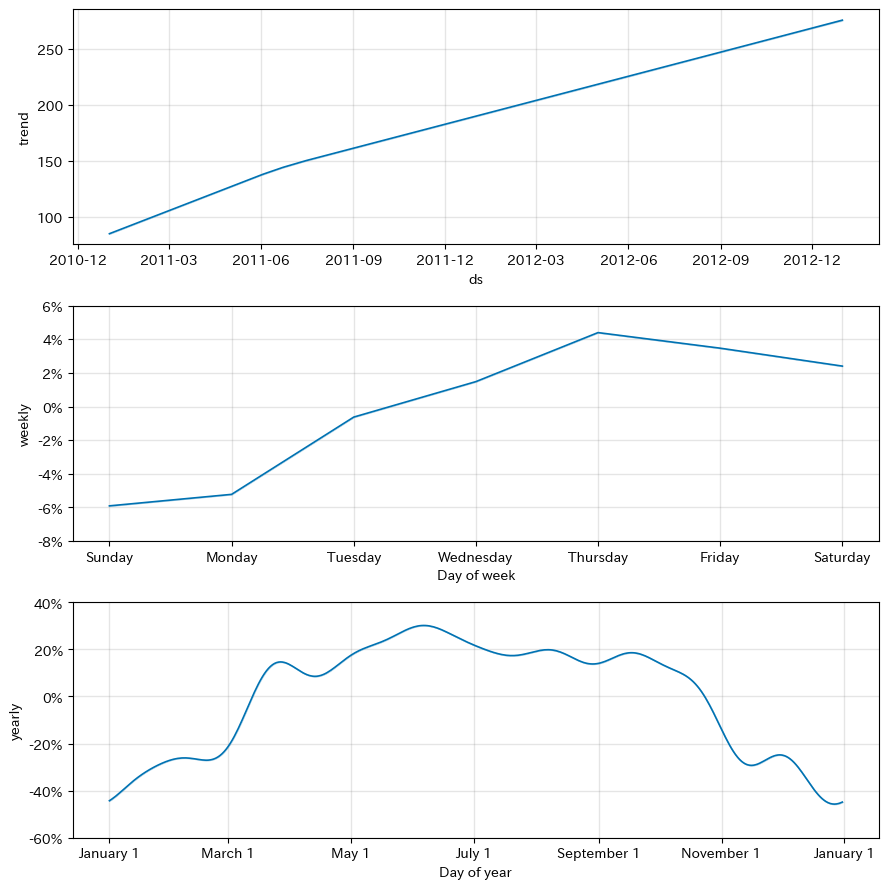

In [193]:
fsct1 = ml.predict(future1)

fig = ml.plot_components(fsct1)

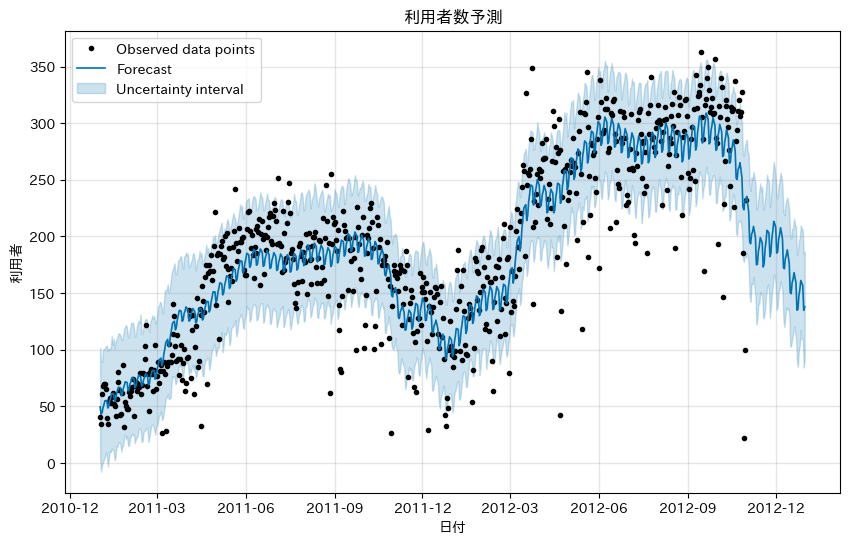

In [206]:
import japanize_matplotlib

fig, ax = plt.subplots(figsize=(10, 6))

ml.plot(fsct1, ax=ax)

ax.set_title('利用者数予測')
ax.set_xlabel('日付')
ax.set_ylabel('利用者')
plt.legend()

黒点が実データ、青線が予測曲線、水色の領域が８０％信頼区間になっている

## 評価

In [207]:
ypred1 = fsct1[-61:][['yhat']].values
#ytest1 = x_test['y'][-61:].values
ytest1 = x_test['y'].values

print(f'{ypred1.shape} / {ytest1.shape}')

from sklearn.metrics import r2_score
score = r2_score(ytest1, ypred1)

print(f'R2 score: {score:.4f}')

(61, 1) / (61,)
R2 score: 0.3123


R2 scoreは１が最良で、負の値になる場合は、外れ値が多い、ということ。

https://www.scsk.jp/sp/mwai/blog/cat/r2.html

Text(0.5, 1.0, '利用者数予測結果')

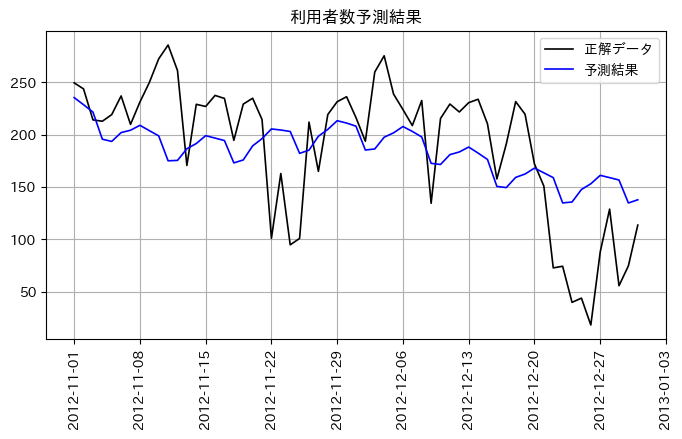

In [208]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(dates_test[-61:], ytest1, label='正解データ', c='k')
ax.plot(dates_test[-61:], ypred1, label='予測結果', c='b')

weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

ax.tick_params(axis='x', rotation=90)
ax.grid()
ax.legend()
ax.set_title('利用者数予測結果')

In [212]:
X0.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,1.0,0.0,1.0,0.0,6.0,0.0,1.583333,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,1.0,0.0,1.0,0.0,0.0,0.0,1.956522,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1.0,0.0,1.0,0.0,1.0,1.0,1.000000,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1.0,0.0,1.0,0.0,2.0,1.0,1.043478,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1.0,0.0,1.0,0.0,3.0,1.0,1.000000,0.226957,0.229270,0.436957,0.186900


## チューニング